In [110]:
import re
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA

# Amazon Review Sentiment Analysis

In this project we will test several models to predict if an Amazon review is negative or positive and then select the best one. We will the test the best model and see if it can make similar prediction on other category reviews

In [111]:
# Load the data
amazon = pd.read_json('C:/Users/keith/Desktop/Thinkful/Patio_Lawn_and_Garden_5.json', lines=True)
 
pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows


In [112]:
amazon.shape

(13272, 9)

In [113]:
amazon.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002N674,"[4, 4]",4,Good USA company that stands behind their prod...,"06 21, 2011",A1JZFGZEZVWQPY,"Carter H ""1amazonreviewer@gmail . com""",Great Hoses,1308614400
1,B00002N674,"[0, 0]",5,This is a high quality 8 ply hose. I have had ...,"06 9, 2014",A32JCI4AK2JTTG,"Darryl Bennett ""Fuzzy342""",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,1402272000
2,B00002N674,"[2, 3]",4,It's probably one of the best hoses I've ever ...,"05 5, 2012",A3N0P5AAMP6XD2,H B,Very satisfied!,1336176000
3,B00002N674,"[0, 0]",5,I probably should have bought something a bit ...,"07 15, 2013",A2QK7UNJ857YG,Jason,Very high quality,1373846400
4,B00002N674,"[1, 1]",5,I bought three of these 5/8-inch Flexogen hose...,"08 5, 2013",AS0CYBAN6EM06,jimmy,Good Hoses,1375660800


## Data Description
This dataset is a small collection of reviews on Patio, Lawn and Garden purchased from Amazon.com. It was downloaded from http://jmcauley.ucsd.edu/data/amazon/. there are 9 columns and 13272 reviews. 

## Data Cleaning

In [114]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 9 columns):
asin              13272 non-null object
helpful           13272 non-null object
overall           13272 non-null int64
reviewText        13272 non-null object
reviewTime        13272 non-null object
reviewerID        13272 non-null object
reviewerName      13107 non-null object
summary           13272 non-null object
unixReviewTime    13272 non-null int64
dtypes: int64(2), object(7)
memory usage: 933.3+ KB


In [115]:
amazon.isnull().sum()

asin                0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      165
summary             0
unixReviewTime      0
dtype: int64

Only one column has null values. It is it the column that contains the name of the reviewer. This columns is not going to be used for our purposes so there is no action needed to be taken.

In [116]:
# count of each class of ratings
amazon.overall.value_counts()

5    7037
4    3384
3    1659
2     673
1     519
Name: overall, dtype: int64

We will create a binary rating feature where anything under a "5" rating is considered negative and will be classed as "0". All the "5" ratings will be positive and classed as a "1".

In [117]:
# create binary ratings feature
amazon['catgry_rate'] = np.where(amazon.overall<5,0,1)
amazon.catgry_rate.value_counts()

1    7037
0    6235
Name: catgry_rate, dtype: int64

The 'unixReviewTime' column isn't very useful and will be converted into datetime. We will also conver the "reviewTime" columns as well.

In [118]:
# convert to datetime
amazon['unixReviewTime'] = pd.to_datetime(amazon.unixReviewTime ,unit='s')
amazon.unixReviewTime.head(2)

0   2011-06-21
1   2014-06-09
Name: unixReviewTime, dtype: datetime64[ns]

In [119]:
amazon['reviewTime'] = pd.to_datetime(amazon.reviewTime)
amazon.reviewTime.head(2)

0   2011-06-21
1   2014-06-09
Name: reviewTime, dtype: datetime64[ns]

In [120]:
# create a feature that stores the lenth of each review
review_length = []
for i in amazon.reviewText:     
         review_length.append(len(i))
amazon['review_length'] = review_length

In [121]:
print(amazon[amazon.catgry_rate==1].review_length.mean())
print(amazon[amazon.catgry_rate==0].review_length.mean())

750.440102316328
959.2368885324779


In [122]:
# check correlation with lenth of review and rating
amazon.catgry_rate.corr(amazon.review_length)

-0.12628107998519295

There seems to be a negative correlation between the lenth of a review and the rating of that review which would imply that the longer the review the more negative the rating. It is a weak correlation but worth noting.

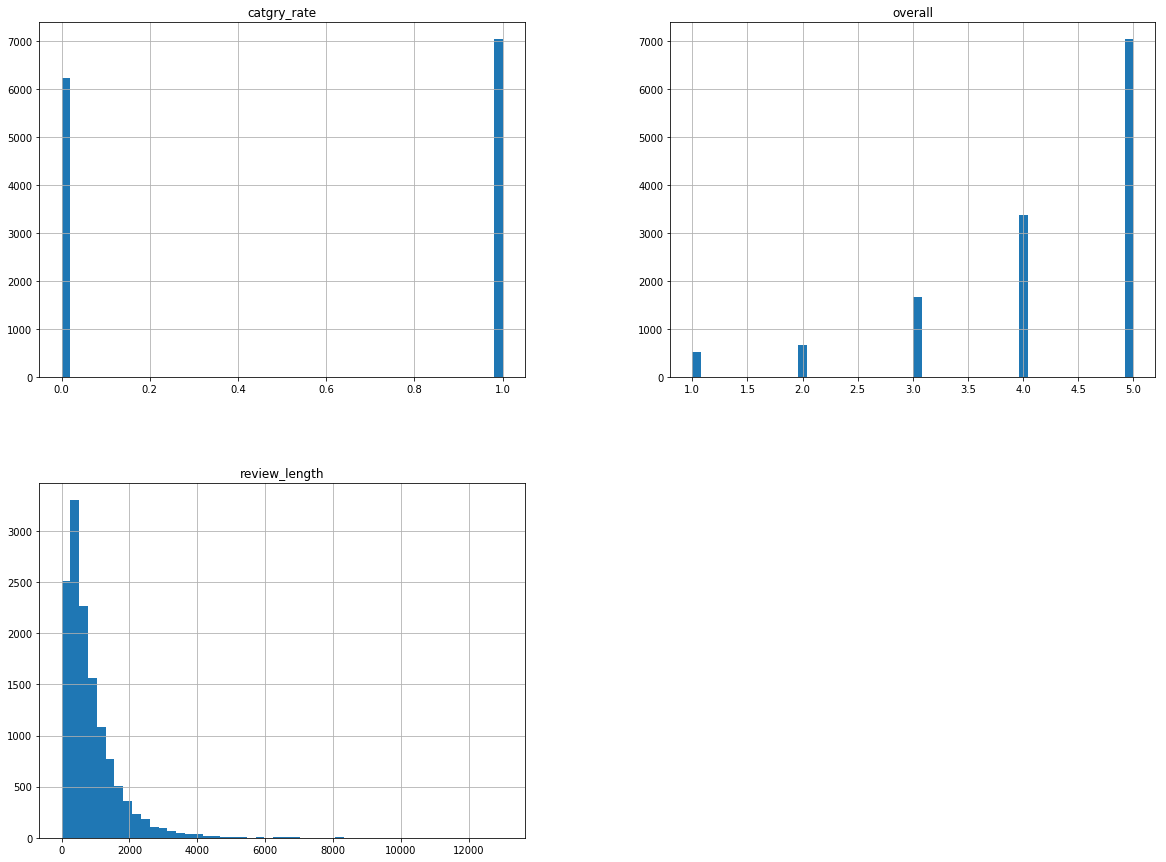

In [123]:
amazon.hist(bins=50,figsize=(20,15))
plt.show()

## Preprocessing
For the purposes of this project we will only use the 'reviewText' conlumn and process it using TfidVectorizor function from sklearn. There will be no other types of processing of the text. 

In [124]:
amazon['reviewText'] = amazon.reviewText.str.replace('[^\w\s]','')
amazon['reviewText'] = amazon.reviewText.str.split()


In [125]:
a=[]
for i in range(len(amazon.reviewText)):
    a.append(pd.Series(amazon.reviewText[i]).unique())

In [126]:
amazon['reviewText'] = a

In [127]:
amazon['reviewText'] = amazon.reviewText.apply((' ,'.join))

In [129]:
amazon.reviewText[:1]

0    Good ,USA ,company ,that ,stands ,behind ,thei...
Name: reviewText, dtype: object

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer
X= amazon.reviewText
Y= amazon.catgry_rate
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

vectorizer = TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#Applying the vectorizer
X_train_tfidf =vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) 

In [203]:
# training set class sizes
y_train.value_counts()

1    5613
0    5004
Name: catgry_rate, dtype: int64

The features are fairly balance so we will keep them as they are unless the model is performing extremely poorly. 

# Modeling

### Naive Bayes

In [204]:
# Instatiate the model

#
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(fit_prior=True)
mnb.fit(X_train_tfidf , y_train)

y_pred = mnb.predict(X_test_tfidf) 

print('Accuracy score :',mnb.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(mnb, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.7171374764595103
ROC_AUC cross validataion score:  [0.73029334 0.74240479 0.75414349 0.7830552  0.73766174]


In [205]:
# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_test,y_pred))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report

target_names = ['negative reviews','positive reviews']
print(classification_report(y_test,y_pred, target_names=target_names))

Consfusion Matrix
col_0          0     1
catgry_rate           
0            740   491
1            260  1164

Classification Report
                  precision    recall  f1-score   support

negative reviews       0.74      0.60      0.66      1231
positive reviews       0.70      0.82      0.76      1424

       micro avg       0.72      0.72      0.72      2655
       macro avg       0.72      0.71      0.71      2655
    weighted avg       0.72      0.72      0.71      2655



AUC: 0.749


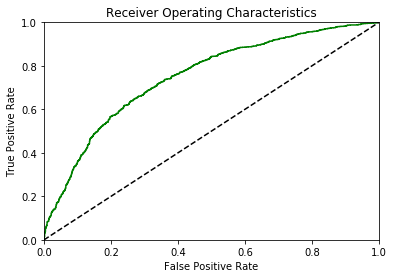

In [206]:
# Function that prints AUC and plots ROC curve
def AUC_ROC_plot(model,X,y,color): 
    y_prob = cross_val_predict(model, X, y, method='predict_proba',cv=5)    
    auc = roc_auc_score(y,y_prob[:,1])
    print('AUC: %.3f' % auc)
    fpr, tpr,thresholds = roc_curve(y,y_prob[:,1])
    plt.plot(fpr,tpr,color)    
    plt.plot([0.0,1.0],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.xlim([0.0,1.0])     
    plt.ylim([0.0,1.0])
AUC_ROC_plot(mnb,X_test_tfidf,y_test,'g')

In [49]:
# initiate GridsearchCV for best parameters
from sklearn.model_selection import GridSearchCV
param_grid = dict(alpha=np.arange(1,5,1),fit_prior=(True,False))
grid = GridSearchCV(mnb, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf , y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 1, 'fit_prior': True}
0.7739424708229142


In [81]:
# refit model with new prams
mnb = MultinomialNB(alpha=1, fit_prior=True)
mnb.fit(X_train_tfidf , y_train)


y_pred = mnb.predict(X_test_tfidf) 
print(mnb.score( X_test_tfidf , y_test,))
print(cross_val_score(mnb, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

0.7171374764595103
[0.73029334 0.74240479 0.75414349 0.7830552  0.73766174]


AUC: 0.749


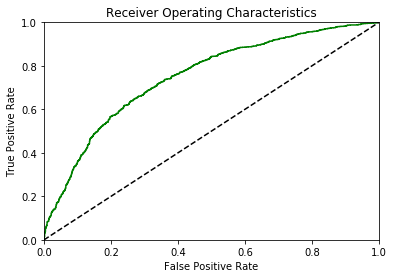

In [82]:
AUC_ROC_plot(mnb,X_test_tfidf,y_test)

In [154]:
# Confusion matrix
print("Consfusion Matrix")
print(pd.crosstab(y_test,y_pred))
print()

# Classification report
print("Classification Report")
from sklearn.metrics import classification_report

target_names = ['negative reviews','positive reviews']
print(classification_report(y_test,y_pred, target_names=target_names))

Consfusion Matrix
col_0          0    1
catgry_rate          
0            908  323
1            465  959

Classification Report
                  precision    recall  f1-score   support

negative reviews       0.66      0.74      0.70      1231
positive reviews       0.75      0.67      0.71      1424

       micro avg       0.70      0.70      0.70      2655
       macro avg       0.70      0.71      0.70      2655
    weighted avg       0.71      0.70      0.70      2655



For this project there is no clear class that we are focused on. Although, we have printed the classification report the most important metric for this purpose is the Area under the ROC curve. This gives us a measure of performance across all possible classification thresholds. The model is not perfoming as well as expected. This is most likely due to the TFidf processing parameters that were chosen. Also, the curve uses the proabilities to predict outcomes to form the curve and Naive Bayes is a bad extimator so the curve itself could be off.

### KNN

In [207]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(algorithm='auto', n_neighbors=10) 
neighbors.fit(X_train_tfidf, y_train)


print('Accuracy score :',neighbors.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(neighbors, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.5450094161958569
ROC_AUC cross validataion score:  [0.65212728 0.68622878 0.67628726 0.69215518 0.6741598 ]


Consfusion Matrix
col_0          0     1
catgry_rate           
0            284   947
1            251  1173

Classification Report
                  precision    recall  f1-score   support

  positve review       0.53      0.23      0.32      1231
negative reviews       0.55      0.82      0.66      1424

       micro avg       0.55      0.55      0.55      2655
       macro avg       0.54      0.53      0.49      2655
    weighted avg       0.54      0.55      0.50      2655

AUC: 0.675


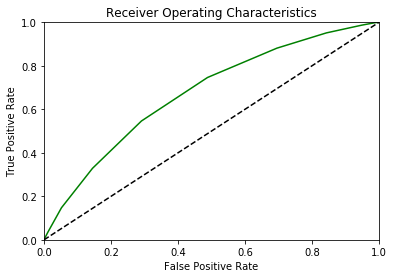

In [157]:
# Confusion matrix
y_pred = neighbors.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_test,y_pred))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(neighbors,X_test_tfidf,y_test,'g')

In [ ]:
# initiate GridsearchCV
param_grid = dict(weights=['distance','uniform'],n_neighbors=range(1,300,5))
grid = GridSearchCV(neighbors, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf , y_train)
print(grid.best_params_)
print(grid.best_score_)

In [208]:
# refit model with new params
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=271,weights='distance',p=2)
neighbors.fit(X_train_tfidf, y_train)


print('Accuracy score :',neighbors.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(mnb, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.6990583804143126
ROC_AUC cross validataion score:  [0.73029334 0.74240479 0.75414349 0.7830552  0.73766174]


Consfusion Matrix
catgry_rate    0     1
row_0                 
0            678   246
1            553  1178

Classification Report
                  precision    recall  f1-score   support

  positve review       0.73      0.55      0.63      1231
negative reviews       0.68      0.83      0.75      1424

       micro avg       0.70      0.70      0.70      2655
       macro avg       0.71      0.69      0.69      2655
    weighted avg       0.71      0.70      0.69      2655

AUC: 0.737


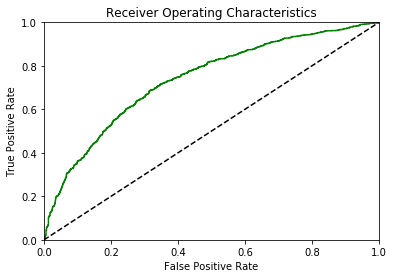

In [209]:
# Confusion matrix
y_pred = neighbors.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(neighbors,X_test_tfidf,y_test,'g')

The model did poorly when n_neighbors was set at 10. Our test set is imbalanced so the neighbors for the under-reperesented class are sparce. Increasing the n_neighbors significantly improved the results. There is still obviouly room for improvment but that could come from better preprocessing.

### Desision trees

In [210]:
from sklearn import tree
# Initialize and train decision tree.
decision_tree = tree.DecisionTreeClassifier(max_features= 'sqrt', random_state=20,)
decision_tree.fit(X_train_tfidf, y_train)
print('Accuracy score :',decision_tree.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(decision_tree, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.5657250470809793
ROC_AUC cross validataion score:  [0.55249663 0.55979889 0.56108258 0.53928113 0.51907993]


Consfusion Matrix
catgry_rate    0    1
row_0                
0            590  512
1            641  912

Classification Report
                  precision    recall  f1-score   support

  positve review       0.54      0.48      0.51      1231
negative reviews       0.59      0.64      0.61      1424

       micro avg       0.57      0.57      0.57      2655
       macro avg       0.56      0.56      0.56      2655
    weighted avg       0.56      0.57      0.56      2655

AUC: 0.546


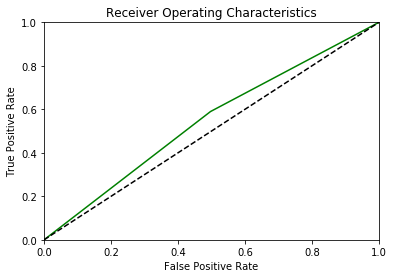

In [211]:
# Confusion matrix
y_pred = decision_tree.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(decision_tree,X_test_tfidf,y_test,'g')

Wow! Terrible results. Almost as good as random chance. This could be caused by the shape of our data, (10617, 490425). There may be few highly predictive features mixed in with low predictive features. Its difficult to say since TFIDF outputs a sparce matrix. We'll try larger values of depth and leaf nodes with GridsearchCV.

In [245]:
# initiate GridsearchCV

param_grid = dict(max_depth=range(30,80,10), max_leaf_nodes=range(300,600,100) )
grid = GridSearchCV(decision_tree, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 60, 'max_leaf_nodes': 300}
0.620375372604108


In [246]:
# refit model with new params
decision_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=300, max_features=None,
                                            max_leaf_nodes=60 ,random_state=20,class_weight='balanced')
decision_tree.fit(X_train_tfidf, y_train)
print('Accuracy score :',decision_tree.score( X_test_tfidf , y_test,))

print('ROC_AUC cross validataion score: ',cross_val_score(decision_tree, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.6497175141242938
ROC_AUC cross validataion score:  [0.66049435 0.61990444 0.57642276 0.6086079  0.59561434]


Consfusion Matrix
catgry_rate    0    1
row_0                
0            743  442
1            488  982

Classification Report
                  precision    recall  f1-score   support

  positve review       0.63      0.60      0.62      1231
negative reviews       0.67      0.69      0.68      1424

       micro avg       0.65      0.65      0.65      2655
       macro avg       0.65      0.65      0.65      2655
    weighted avg       0.65      0.65      0.65      2655

AUC: 0.612


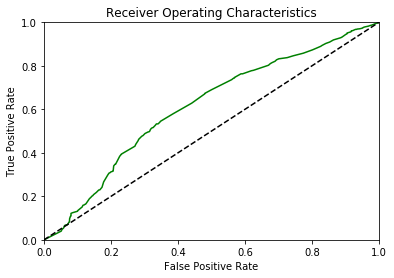

In [247]:
# Confusion matrix
y_pred = decision_tree.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(decision_tree,X_test_tfidf,y_test,'g')

A little better after parameter tuning but not by much.  

### Random forrest

In [249]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# instantiate model
rfc = ensemble.RandomForestClassifier(n_estimators=10) 
rfc.fit(X_train_tfidf,y_train)
print('Accuracy score :',rfc.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(rfc, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.6282485875706215
ROC_AUC cross validataion score:  [0.57040273 0.63170019 0.63521609 0.65548424 0.5836196 ]


Consfusion Matrix
catgry_rate    0    1
row_0                
0            754  510
1            477  914

Classification Report
                  precision    recall  f1-score   support

  positve review       0.60      0.61      0.60      1231
negative reviews       0.66      0.64      0.65      1424

       micro avg       0.63      0.63      0.63      2655
       macro avg       0.63      0.63      0.63      2655
    weighted avg       0.63      0.63      0.63      2655

AUC: 0.627


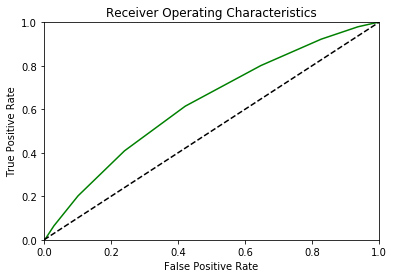

In [250]:
# Confusion matrix
y_pred = rfc.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(rfc, X_test_tfidf, y_test,'g')

In [ ]:
# initiate GridsearchCV
param_grid = dict(max_depth=range(1,6,1), max_leaf_nodes=range(2,10,1))
grid = GridSearchCV(rfc, param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)

In [90]:
# refit model with new params
rfc = ensemble.RandomForestClassifier(n_estimators=1000, max_depth=8, max_leaf_nodes=6,class_weight='balanced') 
rfc.fit(X_train_tfidf, y_train)
print('Accuracy score :',rfc.score( X_test_tfidf , y_test,))
print('ROC_AUC cross validataion score: ',cross_val_score(rfc, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Accuracy score : 0.6444444444444445
ROC_AUC cross validataion score:  [0.71002202 0.7066467  0.71499073 0.72640137 0.6617285 ]


In [ ]:
# Confusion matrix
y_pred = rfc.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_test, y_pred))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(rfc,X_test_tfidf,y_test)

In [ ]:
precision_recall_plot (rfc,X_test_tfidf,y_test) 
plt.show()

In [ ]:
y_prob = rfc.predict_proba(X_test_tfidf)
y_pred_class = binarize(y_prob,0.55)
y_pred_class = y_pred_class[:,1]
 

print('Confusion Matrix:')
print(pd.crosstab( y_test,y_pred))
print()
print('Classification Report')
print(classification_report(y_test ,y_pred, target_names=target_names))
print()

print('Confusion Matrix with binarized class:')
print(pd.crosstab( y_test,y_pred_class))
print()
print('Classification report with binarized class:') 
print(classification_report(y_test ,y_pred_class, target_names=target_names))


### Logistic regression

In [91]:
# Declare a logistic regression classifier.
lr = LogisticRegression(random_state=20, fit_intercept=False ,solver='saga',max_iter=100, penalty='l1',C=1) 
 
# Fit the model.
fit = lr.fit(X_train_tfidf, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
y_pred = lr.predict(X_test_tfidf)

print('\n Accuracy by Motor vehicle theft')
print(pd.crosstab(y_test, y_pred))

print('\n Percentage accuracy: ',lr.score(X_test_tfidf, y_test)) 
print('ROC_AUC cross validataion score: ',cross_val_score(lr, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

Coefficients
[[0. 0. 0. ... 0. 0. 0.]]
[0.]

 Accuracy by Motor vehicle theft
col_0          0     1
catgry_rate           
0            842   389
1            405  1019

 Percentage accuracy:  0.7009416195856873
ROC_AUC cross validataion score:  [0.68510548 0.71664527 0.72789902 0.69512908 0.68166008]


In [ ]:
# Confusion matrix
y_pred = lr.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(lr,X_test_tfidf,y_test)

In [ ]:
# initiate GridsearchCV
param_grid = dict(max_iter=range(8,15,1),class_weight=(None,'balanced'),C=np.arange(.1,4,.1))
grid = GridSearchCV(lr,param_grid, cv=3, scoring='roc_auc', return_train_score=True)
grid.fit(X_train_tfidf, y_train)



In [251]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 60, 'max_leaf_nodes': 300}
0.620375372604108


In [92]:
lr = LogisticRegression(random_state=20, fit_intercept=False ,solver='liblinear',class_weight='balanced', max_iter=3, penalty='l1',C=.9) 
 
# refit the model with new params.
fit = lr.fit(X_train_tfidf, y_train)

# Display 
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
y_pred = lr.predict(X_test_tfidf)

print('\n Confusion Matrix')
print(pd.crosstab(y_pred, y_test))

print('\nAccuracy: ',lr.score(X_test_tfidf, y_test)) 
print('ROC_AUC cross validataion score: ',cross_val_score(lr, X_test_tfidf , y_test, cv=5,scoring='roc_auc'))

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Coefficients
[[0. 0. 0. ... 0. 0. 0.]]
0.0

 Confusion Matrix
catgry_rate    0    1
row_0                
0            908  465
1            323  959

Accuracy:  0.7032015065913371


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ROC_AUC cross validataion score:  [0.69112153 0.71584653 0.71746541 0.69164171 0.6734799 ]


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Confusion matrix
y_pred = lr.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(lr,X_test_tfidf,y_test)

In [ ]:
precision_recall_plot (lr,X_test_tfidf,y_test) 
plt.show()

In [ ]:
y_prob = lr.predict_proba(X_test_tfidf)
y_pred_class = binarize(y_prob,0.50)
y_pred_class = y_pred_class[:,1]
 

print('Confusion Matrix:')
print(pd.crosstab( y_test,y_pred))
print()
print('Classification Report')
print(classification_report(y_test ,y_pred, target_names=target_names))
print()

print('Confusion Matrix with binarized class:')
print(pd.crosstab( y_test,y_pred_class))
print()
print('Classification report with binarized class:') 
print(classification_report(y_test ,y_pred_class, target_names=target_names))


### SVM

In [93]:
from sklearn.svm import SVC
svc = SVC(gamma='auto',probability=True) 
svc.fit(X_train_tfidf,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
# Confusion matrix
y_pred = svc.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(svc,X_test_tfidf,y_test)

In [ ]:
param_grid = dict(C=np.arange(.1,5,.1))
grid = GridSearchCV(svc, param_grid, cv=3, scoring="roc_auc", return_train_score=True,n_jobs = -1)
grid.fit(X_train_tfidf, y_train)


print(grid.best_params_)
print(grid.best_score_ )

In [98]:
# refit model with new params
svc = SVC(kernel='linear',class_weight='balanced',probability=True) 
svc.fit(X_train_tfidf, y_train)

KeyboardInterrupt: 

In [ ]:
# Confusion matrix
y_pred = svc.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(svc,X_test_tfidf,y_test)

In [ ]:
precision_recall_plot (svc,X_test_tfidf,y_test) 
plt.show()

In [ ]:
y_prob = svc.predict_proba(X_test_tfidf)
y_pred_class = binarize(y_prob,0.51)
y_pred_class = y_pred_class[:,1]
 

print('Confusion Matrix:')
print(pd.crosstab( y_test,y_pred))
print()
print('Classification Report')
print(classification_report(y_test ,y_pred, target_names=target_names))
print()

print('Confusion Matrix with binarized class:')
print(pd.crosstab( y_test,y_pred_class))
print()
print('Classification report with binarized class:') 
print(classification_report(y_test ,y_pred_class, target_names=target_names))


### Gradient boost

In [95]:
from sklearn import ensemble 

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=2,
                                          loss='deviance', random_state=20) 
clf.fit(X_train_tfidf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=20,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
# Confusion matrix
y_pred = clf.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(clf,X_test_tfidf,y_test)

In [ ]:
# initiate GridsearchCV
param_grid = dict(max_depth=range(1,6,1), max_leaf_nodes=range(2,10,1))
grid = GridSearchCV(clf, param_grid, cv=3, scoring="f1", return_train_score=True)
grid.fit(X_train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)

In [96]:
# refit model with new params.
clf = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=2,
                                          loss='deviance', random_state=20) 
clf.fit(X_train_tfidf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=20,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
# Confusion matrix
y_pred = clf.predict(X_test_tfidf) 
print("Consfusion Matrix")
print(pd.crosstab(y_pred, y_test))
print()


# Classification report
print("Classification Report") 
target_names = ['positve review','negative reviews']
print(classification_report(y_test ,y_pred, target_names=target_names))
# plot ROC
AUC_ROC_plot(clf,X_test_tfidf,y_test)

In [ ]:
precision_recall_plot (clf,X_test_tfidf,y_test) 
plt.show()

In [ ]:
y_prob = clf.predict_proba(X_test_tfidf)
y_pred_class = binarize(y_prob,0.51)
y_pred_class = y_pred_class[:,1]
 

print('Confusion Matrix:')
print(pd.crosstab( y_test,y_pred))
print()
print('Classification Report')
print(classification_report(y_test ,y_pred, target_names=target_names))
print()

print('Confusion Matrix with binarized class:')
print(pd.crosstab( y_test,y_pred_class))
print()
print('Classification report with binarized class:') 
print(classification_report(y_test ,y_pred_class, target_names=target_names))


In [103]:
models = [mnb, neighbors, decision_tree, rfc, lr, svc, clf]

In [ ]:
for model in models:
    

AUC: 0.749
AUC: 0.675
AUC: 0.623
AUC: 0.706


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packa

AUC: 0.696
AUC: 0.760
AUC: 0.717


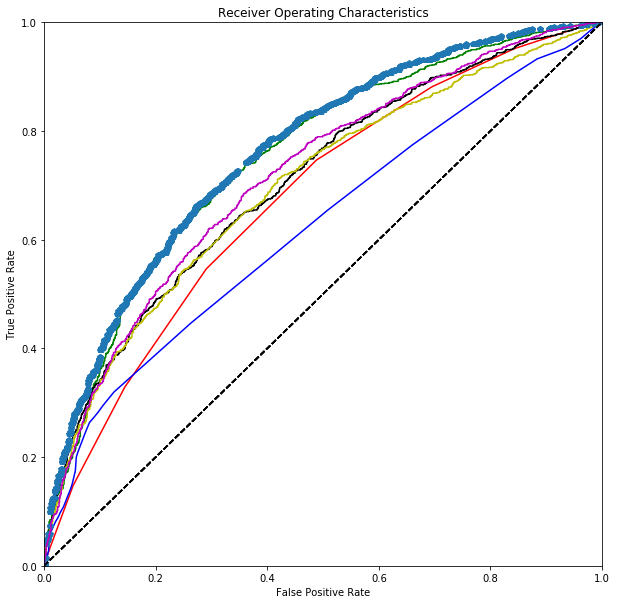

In [133]:
from sklearn.model_selection import learning_curve
 

#mnb = MultinomialNB(fit_prior=True)
#mnb.fit(X_train_tfidf , y_train)
 
train_sizes, train_scores, valid_scores = learning_curve(mnb, X_train_tfidf, y_train, train_sizes=[50, 80, 110], cv=5)
 

In [134]:
train_sizes

array([ 50,  80, 110])

In [135]:
train_scores

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [136]:
valid_scores

array([[0.5287194 , 0.5287194 , 0.5287194 , 0.52849741, 0.52874647],
       [0.5287194 , 0.53013183, 0.52919021, 0.53179463, 0.52921772],
       [0.5287194 , 0.5287194 , 0.53013183, 0.52943947, 0.52827521]])

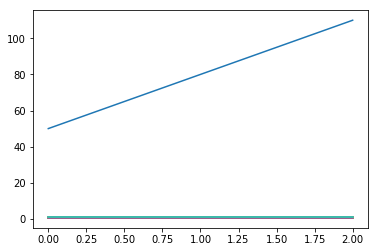

In [139]:
plt.plot(valid_scores)
plt.plot(train_scores)
plt.plot(train_sizes)

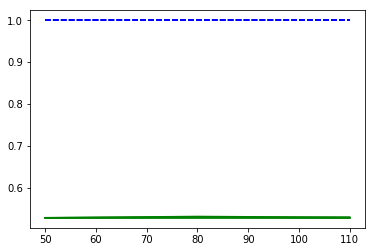

In [142]:
plt.plot(train_sizes,train_scores,"b--",label="Precision")
plt.plot(train_sizes,valid_scores,"g-",label="Recall")

Text(0.5, 0, 'n_neighbors')

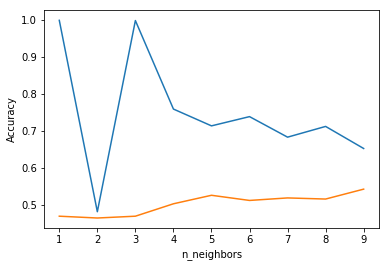

In [153]:
training_accuracy = [] 
test_accuracy = [] # try n_neighbors from 1 to 10 
neighbors_settings = range(1, 10)


for n_neighbors in neighbors_settings:     
    f = KNeighborsClassifier(n_neighbors=n_neighbors)    
    f.fit(X_train_tfidf, y_train)    # record training set accuracy    
    training_accuracy.append(f.score(X_train_tfidf, y_train))    # record generalization accuracy    
    test_accuracy.append(f.score(X_test_tfidf, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("n_neighbors")